# Imports

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import os
import torchvision.transforms.functional as F
import torchvision.transforms
import torch.optim.lr_scheduler as lr_scheduler
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import torch.optim as optim
from skimage.transform import radon, iradon
from skimage.io import imread
from PIL import Image
from scipy.ndimage import rotate


# Directiry Setup

In [ ]:
drive.mount('/content/drive')
os.chdir('/content/drive/Othercomputers/My MacBook Pro/Mega/Master Studies/Studying/Introduction to Deep Learning (18786)/Mini project/Miniproject')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Data

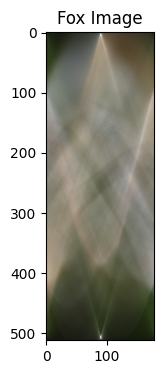

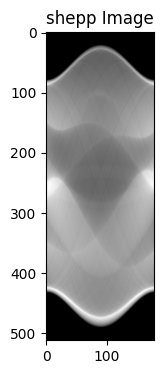

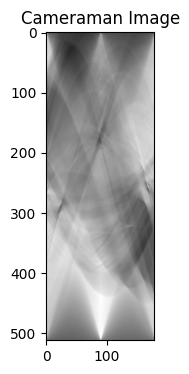

In [ ]:
image_fox = plt.imread('data/radon/fox.tiff')/255.0
data_fox = np.load('data/radon/fox.npy') 
plt.figure(figsize=(4, 4)) # initiate figure
plt.imshow(image_fox)
plt.title('Fox Image')
plt.show()
image_fox = plt.imread('data/image/fox.jpg')/255.0


image_shepp = plt.imread('data/radon/shepp.tiff')/255.0
data_shepp = np.load('data/radon/shepp.npy')
# data_shepp = np.stack((data_shepp[:,:,0], data_shepp[:,:,0], data_shepp[:,:,0]), axis=-1)
plt.figure(figsize=(4, 4)) # initiate figure
plt.imshow(image_shepp)
plt.title('shepp Image')
plt.show()

image_man = plt.imread('data/radon/cameraman.tiff')/255.0
data_cameraman = np.load('data/radon/cameraman.npy')
# data_cameraman = np.stack((data_cameraman[:,:,0], data_cameraman[:,:,0], data_cameraman[:,:,0]), axis=-1)
plt.figure(figsize=(4, 4)) # initiate figure
plt.imshow(image_man)
plt.title('Cameraman Image')
plt.show()

## Notes on images:


*   **Cameraman:** the image is three channels, but the numpy data is single channel
*   **Shepp:** the image is three channels, but the numpy data is single channel
*   **Fox:** Both are three channels





# Cameraman Image

## Prepare input and output data

In [ ]:
## Input Features:
p = np.linspace(0, 1, 512)
q = np.linspace(0, 1, 512)
X = np.meshgrid(p, q)
X = np.stack(X, axis=-1).reshape(-1, 2).astype(np.float32)
# X = torch.from_numpy(X) # to tensor

## Forier features:
b = np.random.normal(0, 100, (512,2))
cos_b = np.cos(2 * np.pi * (X@b.T))
sin_b = np.sin(2 * np.pi * (X@b.T))
X = np.zeros((X.shape[0], b.shape[0]*2))
X[:,0::2] = cos_b
X[:,1::2] = sin_b
X = torch.from_numpy(X) # to tensor
X = X.to(torch.float32)

## Output labels:
y = data_cameraman.reshape(-1, data_cameraman.shape[-1]).astype(np.float32)
y = torch.from_numpy(y) # to tensor

## Output shape:
out_dim = 1

## Define network

In [ ]:
# Define MLP architecture
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, 512)
        self.fc5 = nn.Linear(512, 256)
        self.fc6 = nn.Linear(256, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.sigmoid(self.fc6(x))

        return x

## Define radon transform

In [ ]:
class radon_loss(nn.Module):
  def __init__(self):
        super(radon_loss, self).__init__()

  def forward(self, output, target):
    theta = torch.arange(0, 180, dtype=float, requires_grad=True)
    output = output.reshape(512,512,1)

    for ii, angle in enumerate(theta):
      image_man_rotate = F.rotate(output.permute(2,0,1), float(angle))
      image_man_rotate = image_man_rotate.permute(1,2,0)

      # plt.imshow(image_man_rotate, cmap=plt.get_cmap('gray'))
      # plt.show()

      if ii == 0: image_radon_angle = torch.sum(image_man_rotate, dim=1).unsqueeze(1)
      else: image_radon_angle = torch.cat((image_radon_angle, torch.sum(image_man_rotate, dim=1).unsqueeze(1)), dim=1)
    
    criterion = nn.MSELoss()
    loss = criterion(image_radon_angle.reshape(-1,1).float(), target.reshape(-1,1).float())
    # loss = 0

    return image_radon_angle, loss


## Train and Test

In [ ]:
## Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Define network:
net = MLP(input_dim=X.shape[-1], output_dim=out_dim).to(device)

# define optimizer and loss:
criterion = radon_loss()
optimizer = optim.Adam(net.parameters(),  lr=0.001)

## Train the model
num_epochs = 1000
num_samples = X.shape[0]
psnr_list = []
ssim_list = []
loss_list = []

for epoch in range(num_epochs):

  # get data to device
  X = X.to(device)
  y = y.to(device)

  # Forward pass
  y_pred = net(X)

  # Loss
  _, loss = criterion(y_pred, y)

  # Backward pass and optimization
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Calculate PSNR and SSIM and append to list
  y_pred = y_pred.detach().cpu().numpy()
  image_pred = y_pred.reshape((512, 512, 1))
  image_pred = np.flip(rotate(image_pred, -90, reshape=True, order=1, mode='constant', cval=0, prefilter=True), axis=1)

  loss_list.append(loss.item())

  # Print loss after every epoch
  print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, PSNR: {0:.4f}, SSIM: {0:.4f}')

Epoch [1/1000], Loss: 7.4544, PSNR: 0.0000, SSIM: 0.0000


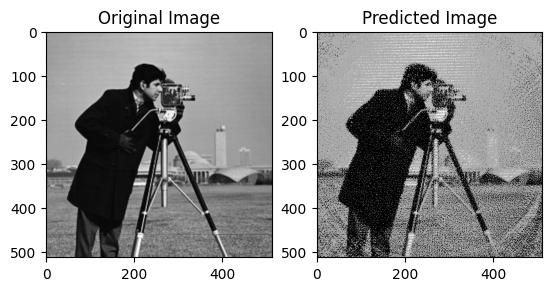

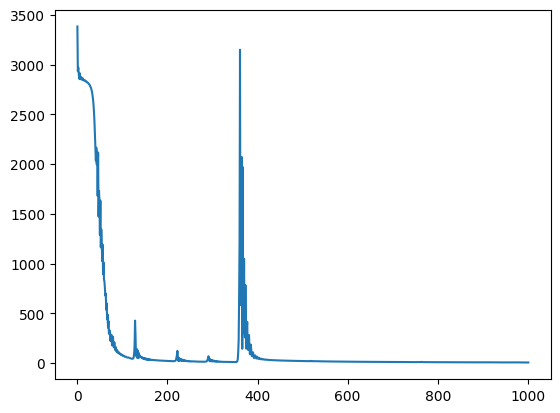

In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image_man/image_man.max(), cmap=plt.get_cmap('gray'))
ax[0].set_title('Original Image')
ax[1].imshow(image_pred/image_pred.max(), cmap=plt.get_cmap('gray'))
ax[1].set_title('Predicted Image')
plt.show()

plt.show()
image_pred.shape

plt.plot(loss_list)

# Shepp Image

## Prepare input and output data

In [136]:
## Input Features:
p = np.linspace(0, 1, 512)
q = np.linspace(0, 1, 512)
X = np.meshgrid(p, q)
X = np.stack(X, axis=-1).reshape(-1, 2).astype(np.float32)

## Forier features:
b = np.random.normal(0, 100, (512,2))
cos_b = np.cos(2 * np.pi * (X@b.T))
sin_b = np.sin(2 * np.pi * (X@b.T))
X = np.zeros((X.shape[0], b.shape[0]*2))
X[:,0::2] = cos_b
X[:,1::2] = sin_b
X = torch.from_numpy(X) # to tensor
X = X.to(torch.float32)

## Output labels:
y = data_shepp.reshape(-1, data_shepp.shape[-1]).astype(np.float32)
y = torch.from_numpy(y) # to tensor

## Output shape:
out_dim = 1


torch.Size([92160, 1])

## Define network

In [130]:
# Define MLP architecture
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, 512)
        self.fc5 = nn.Linear(512, 256)
        self.fc6 = nn.Linear(256, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.sigmoid(self.fc6(x))

        return x

## Define radon transform

In [131]:
class radon_loss(nn.Module):
  def __init__(self):
        super(radon_loss, self).__init__()

  def forward(self, output, target):
    theta = torch.arange(0, 180, dtype=float, requires_grad=True)
    output = output.reshape(512,512,1)

    for ii, angle in enumerate(theta):
      image_man_rotate = F.rotate(output.permute(2,0,1), float(angle))
      image_man_rotate = image_man_rotate.permute(1,2,0)

      # plt.imshow(image_man_rotate, cmap=plt.get_cmap('gray'))
      # plt.show()

      if ii == 0: image_radon_angle = torch.sum(image_man_rotate, dim=1).unsqueeze(1)
      else: image_radon_angle = torch.cat((image_radon_angle, torch.sum(image_man_rotate, dim=1).unsqueeze(1)), dim=1)

    criterion = nn.MSELoss()
    loss = criterion(image_radon_angle.reshape(-1,1).float(), target.reshape(-1,1).float())
    # loss = 0

    return image_radon_angle, loss


## Train and Test

In [142]:
## Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Define network:
net = MLP(input_dim=X.shape[-1], output_dim=out_dim).to(device)

# define optimizer and loss:
criterion = radon_loss()
optimizer = optim.Adam(net.parameters(),  lr=0.001)

## Train the model
num_epochs = 1000
num_samples = X.shape[0]
psnr_list = []
ssim_list = []
loss_shepp_list = []

for epoch in range(num_epochs):

  # get data to device
  X = X.to(device)
  y = y.to(device)

  # Forward pass
  y_pred = net(X)

  # Loss
  _, loss = criterion(y_pred, y)

  # Backward pass and optimization
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Calculate PSNR and SSIM and append to list
  y_pred = y_pred.detach().cpu().numpy()
  image_pred = y_pred.reshape((512, 512, 1))
  image_pred = np.flip(rotate(image_pred, -90, reshape=True, order=1, mode='constant', cval=0, prefilter=True), axis=1)

  loss_shepp_list.append(loss.item())

  # Print loss after every epoch
  print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, PSNR: {0:.4f}, SSIM: {0:.4f}')

Epoch [1/1000], Loss: 27327.3613, PSNR: 0.0000, SSIM: 0.0000
Epoch [2/1000], Loss: 26387.0703, PSNR: 0.0000, SSIM: 0.0000
Epoch [3/1000], Loss: 25510.7090, PSNR: 0.0000, SSIM: 0.0000
Epoch [4/1000], Loss: 24660.5234, PSNR: 0.0000, SSIM: 0.0000
Epoch [5/1000], Loss: 23778.5371, PSNR: 0.0000, SSIM: 0.0000
Epoch [6/1000], Loss: 22817.8223, PSNR: 0.0000, SSIM: 0.0000
Epoch [7/1000], Loss: 21715.0391, PSNR: 0.0000, SSIM: 0.0000
Epoch [8/1000], Loss: 20431.3477, PSNR: 0.0000, SSIM: 0.0000
Epoch [9/1000], Loss: 18941.0098, PSNR: 0.0000, SSIM: 0.0000
Epoch [10/1000], Loss: 17216.0176, PSNR: 0.0000, SSIM: 0.0000
Epoch [11/1000], Loss: 15247.3223, PSNR: 0.0000, SSIM: 0.0000
Epoch [12/1000], Loss: 13045.2627, PSNR: 0.0000, SSIM: 0.0000
Epoch [13/1000], Loss: 10653.5928, PSNR: 0.0000, SSIM: 0.0000
Epoch [14/1000], Loss: 8169.2559, PSNR: 0.0000, SSIM: 0.0000
Epoch [15/1000], Loss: 5753.9819, PSNR: 0.0000, SSIM: 0.0000
Epoch [16/1000], Loss: 3617.3828, PSNR: 0.0000, SSIM: 0.0000
Epoch [17/1000], Los

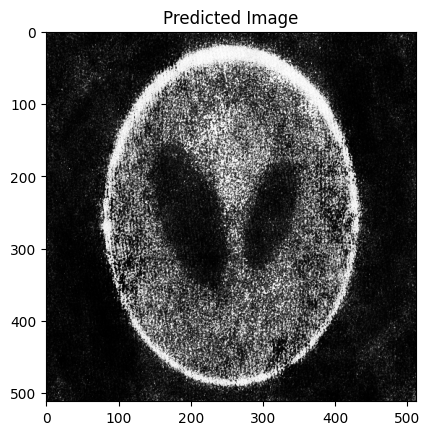

Text(0.5, 1.0, 'Loss vs. epoch')

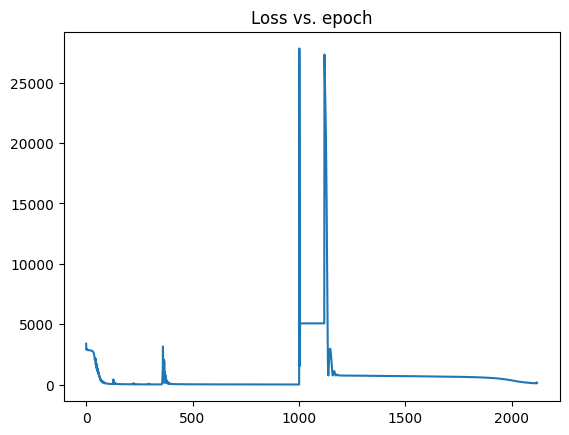

In [144]:
plt.imshow(image_pred/image_pred.max(), cmap=plt.get_cmap('gray'))
plt.title('Predicted Image')
plt.show()
plt.plot(loss_list)
plt.title('Loss vs. epoch')


# Fox Image

## Prepare input and output data

In [4]:
## Input Features:
p = np.linspace(0, 1, 512)
q = np.linspace(0, 1, 512)
X = np.meshgrid(p, q)
X = np.stack(X, axis=-1).reshape(-1, 2).astype(np.float32)
# X = torch.from_numpy(X) # to tensor

## Forier features:
b = np.random.normal(0, 100, (512,2))
cos_b = np.cos(2 * np.pi * (X@b.T))
sin_b = np.sin(2 * np.pi * (X@b.T))
X = np.zeros((X.shape[0], b.shape[0]*2))
X[:,0::2] = cos_b
X[:,1::2] = sin_b
X = torch.from_numpy(X) # to tensor
X = X.to(torch.float32)

## Output labels:
y = data_fox.reshape(-1, data_shepp.shape[-1]).astype(np.float32)
y = torch.from_numpy(y) # to tensor

## Output shape:
out_dim = 3


## Define network

In [5]:
# Define MLP architecture
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, 512)
        self.fc5 = nn.Linear(512, 256)
        self.fc6 = nn.Linear(256, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.sigmoid(self.fc6(x))

        return x

## Define radon transform

In [6]:
class radon_loss(nn.Module):
  def __init__(self):
        super(radon_loss, self).__init__()

  def forward(self, output, target):
    theta = torch.arange(0, 180, dtype=float, requires_grad=True)
    output = output.reshape(512,512,3)

    for ii, angle in enumerate(theta):
      image_man_rotate = F.rotate(output.permute(2,0,1), float(angle))
      image_man_rotate = image_man_rotate.permute(1,2,0)

      # plt.imshow(image_man_rotate, cmap=plt.get_cmap('gray'))
      # plt.show()

      if ii == 0: image_radon_angle = torch.sum(image_man_rotate, dim=1).unsqueeze(1)
      else: image_radon_angle = torch.cat((image_radon_angle, torch.sum(image_man_rotate, dim=1).unsqueeze(1)), dim=1)

    criterion = nn.MSELoss()
    loss = criterion(image_radon_angle.reshape(-1,1).float(), target.reshape(-1,1).float())
    # loss = 0

    return image_radon_angle, loss


## Train and Test

In [8]:
## Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Define network:
net = MLP(input_dim=X.shape[-1], output_dim=out_dim).to(device)

# define optimizer and loss:
criterion = radon_loss()
optimizer = optim.Adam(net.parameters(),  lr=0.001)

## Train the model
num_epochs = 1000
num_samples = X.shape[0]
psnr_list = []
ssim_list = []
loss_fox_list = []

for epoch in range(num_epochs):

  # get data to device
  X = X.to(device)
  y = y.to(device)

  # Forward pass
  y_pred = net(X)

  # Loss
  _, loss = criterion(y_pred, y)

  # Backward pass and optimization
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Calculate PSNR and SSIM and append to list
  y_pred = y_pred.detach().cpu().numpy()
  image_pred = y_pred.reshape((512, 512, 3))
  image_pred = np.flip(rotate(image_pred, -90, reshape=True, order=1, mode='constant', cval=0, prefilter=True), axis=1)

  # print('here5: ', image_pred.dtype.type)
  psnr = peak_signal_noise_ratio(image_fox, image_pred)
  ssim = structural_similarity(image_fox, image_pred, multichannel=True)
  psnr_list.append(psnr)
  ssim_list.append(ssim)
  loss_fox_list.append(loss.item())

  # Print loss after every epoch
  print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, PSNR: {psnr:.4f}, SSIM: {ssim:.4f}')

<ipython-input-8-ecfaa7e370cd>:41: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(image_fox, image_pred)
<ipython-input-8-ecfaa7e370cd>:42: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = structural_similarity(image_fox, image_pred, multichannel=True)


Epoch [1/1000], Loss: 3247.2656, PSNR: 10.9541, SSIM: 0.4857
Epoch [2/1000], Loss: 3059.3152, PSNR: 11.0753, SSIM: 0.4909
Epoch [3/1000], Loss: 3072.8787, PSNR: 11.0469, SSIM: 0.4894
Epoch [4/1000], Loss: 3049.7898, PSNR: 11.0661, SSIM: 0.4903
Epoch [5/1000], Loss: 3029.4919, PSNR: 11.0948, SSIM: 0.4920
Epoch [6/1000], Loss: 3024.6328, PSNR: 11.0875, SSIM: 0.4912
Epoch [7/1000], Loss: 3024.2153, PSNR: 11.0672, SSIM: 0.4897
Epoch [8/1000], Loss: 3026.5715, PSNR: 11.0605, SSIM: 0.4893
Epoch [9/1000], Loss: 3021.5325, PSNR: 11.0673, SSIM: 0.4897
Epoch [10/1000], Loss: 3014.6252, PSNR: 11.0828, SSIM: 0.4907
Epoch [11/1000], Loss: 3015.2703, PSNR: 11.0984, SSIM: 0.4918
Epoch [12/1000], Loss: 3014.0181, PSNR: 11.1027, SSIM: 0.4920
Epoch [13/1000], Loss: 3010.0017, PSNR: 11.0966, SSIM: 0.4915
Epoch [14/1000], Loss: 3009.7454, PSNR: 11.0900, SSIM: 0.4910
Epoch [15/1000], Loss: 3007.6953, PSNR: 11.0903, SSIM: 0.4909
Epoch [16/1000], Loss: 3002.9583, PSNR: 11.0980, SSIM: 0.4912
Epoch [17/1000], 

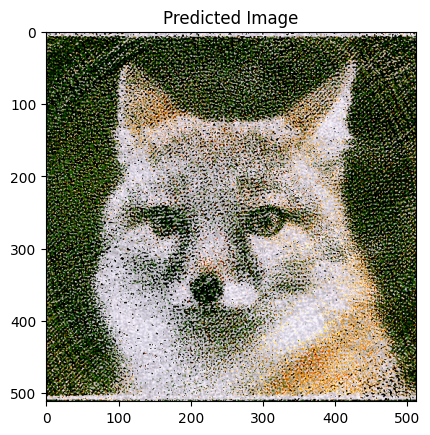

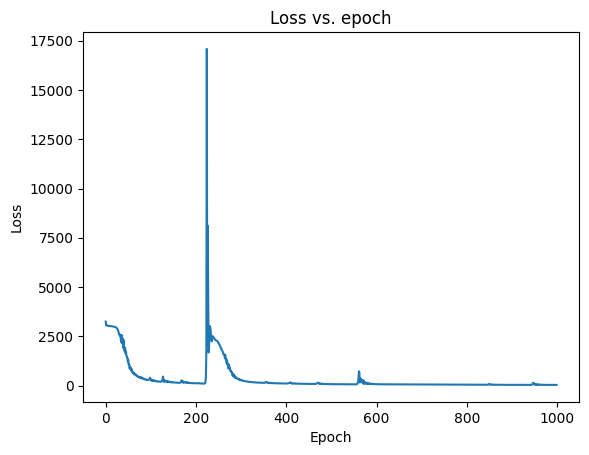

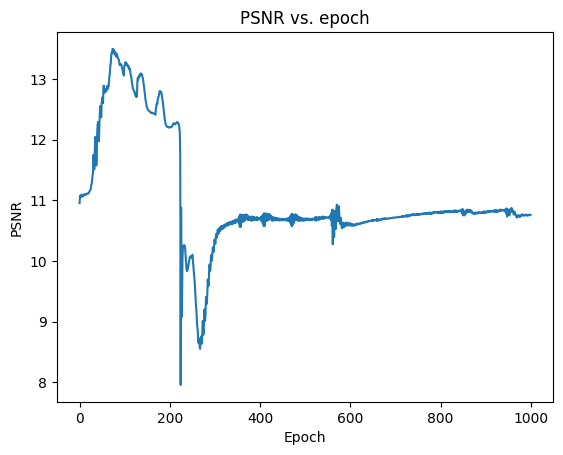

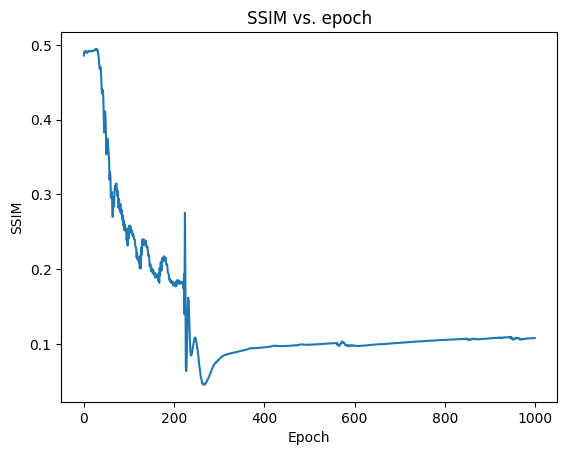

In [11]:
plt.imshow(image_pred/image_pred.max(), cmap=plt.get_cmap('gray'))
plt.title('Predicted Image')
plt.show()

plt.plot(loss_fox_list)
plt.title('Loss vs. epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(psnr_list)
plt.title('PSNR vs. epoch')
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.show()

plt.plot(ssim_list)
plt.title('SSIM vs. epoch')
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.show() 